In [1]:
import sys
import os
import sys
import os
# Add the parent directory of TRVQA to sys.path
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../..')))
from TRVQA.measure.enums import MeasureMethod
from TRVQA.optimization.gradients.vanilla_parameter_shift import vanilla_parameter_shift
from TRVQA.optimization.optimization import minimize, minimize_custom
from TRVQA.utils.maxcut import gengraph, create_hamiltonian, make_hamiltonian
import torch
from torch.autograd import Function
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit import QuantumCircuit

import numpy as np
import torch
from TRVQA.circuit import Circuit

def compute_maxcut_value(bitstring, graph):
    """Computes the MaxCut value for a given bitstring solution."""
    cut_value = sum(w for (u,v), w in graph if bitstring[u] != bitstring[v])
    return cut_value

# for s in best_value:
#     print(compute_maxcut_value(s, g))

from pyparsing import Optional
import torch
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
from TRVQA.optimization.optimization import minimize, minimize_custom
# TRVQA imports

from TRVQA.circuit import Circuit
from TRVQA.hamiltonian.hamiltonian import Hamiltonian
from TRVQA.measure.enums import MeasureMethod
torch.cuda.empty_cache()
import numpy as np
import torch
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
import torch

from TRVQA.measure.enums import MeasureMethod
from TRVQA.optimization.optimization import minimize
from TRVQA.utils.maxcut import gengraph, create_hamiltonian,make_hamiltonian
from TRVQA.hamiltonian.hamiltonian import Hamiltonian
import numpy as np
import torch
from TRVQA.circuit import Circuit
import time


In [2]:
import gurobipy as gp
from gurobipy import GRB
import networkx as nx

def maxcut_value(G, maximize=GRB.MAXIMIZE) -> float:
    """
    Solve weighted Max-Cut on an undirected NetworkX graph using Gurobi.

    Args:
        G: networkx.Graph
           Undirected graph. Edge weights read from attribute 'weight' (default 1.0).

    Returns:
        float: Optimal Max-Cut value.
    """
    # if not isinstance(G, nx.Graph) or G.is_directed():
    #     raise ValueError("G must be an undirected networkx.Graph")

    model = gp.Model("MaxCut")
    model.Params.OutputFlag = 0  # silence solver output

    # Binary variable x[i] ∈ {0,1} indicates partition side of node i
    #nodes = list(G.nodes())
    # Number of nodes
    nodes = set()
    for e,w in G:
        u,v = e
        nodes.add(u)
        nodes.add(v)
    n = len(nodes)

    x = model.addVars(nodes, vtype=GRB.BINARY, name="x")
    # Objective: Maximize the cut value
    model.setObjective(
        gp.quicksum(w * (x[u] + x[v] - 2 * x[u] * x[v]) for (u, v), w in G),
        maximize
    )

    # Optimize the model
    model.optimize()


    if model.Status != GRB.OPTIMAL:
        raise RuntimeError(f"Gurobi did not find an optimal solution (status={model.Status}).")

    return float(model.ObjVal)


In [3]:
import json
with open("experiment_grid.json", "r") as f:
    loaded = json.load(f)

# Convert lists back to tuples if you want
def convert_lists_to_tuples(obj):
    if isinstance(obj, list):
        # Check if list looks like an edge [(0,1), w]
        if len(obj) == 2 and isinstance(obj[0], list) and isinstance(obj[1], (int, float)):
            return (tuple(obj[0]), obj[1])
        else:
            return [convert_lists_to_tuples(x) for x in obj]
    if isinstance(obj, dict):
        return {k: convert_lists_to_tuples(v) for k, v in obj.items()}
    return obj

exp_grid_loaded = [convert_lists_to_tuples(entry) for entry in loaded]

print(exp_grid_loaded[0])  # should match your original structure
# {'N': 4, 'graph_id': 0, 'seed': 45854826, 'G': [((0, 3), 3), ((0, 2), 1), ((0, 1), 5), ((1, 2), 7), ((1, 3), 8), ((2, 3), 8)], 'depth': 1}


{'N': 4, 'graph_id': 0, 'seed': 45854826, 'G': [((0, 3), 3), ((0, 2), 1), ((0, 1), 5), ((1, 2), 7), ((1, 3), 8), ((2, 3), 8)], 'depth': 1}


In [4]:
# =========================
# Reading + Plotting Utils
# =========================
import os, csv, json
from typing import List, Dict, Any, Tuple
import torch
import matplotlib.pyplot as plt

# ---------- Readers ----------
def read_summary(summary_csv: str = "bench_out/summary.csv") -> List[Dict[str, Any]]:
    """
    Returns a list of dict rows:
      run_id, method, N, seed, theta_path, iter_csv
    """
    rows = []
    with open(summary_csv, "r") as f:
        r = csv.DictReader(f)
        for row in r:
            row["N"] = int(row["N"])
            row["seed"] = int(row["seed"])
            rows.append(row)
    return rows

def read_iter_csv(run_id: str, outdir: str = "bench_out") -> Dict[str, List[Any]]:
    """
    Reads per-iteration CSV for a single run and returns:
      {"iter": [...], "exp_values": [...], "best_results": [...], "iter_times": [...]}
    """
    path = os.path.join(outdir, f"iter_{run_id}.csv")
    iters, exp_values, best_results, iter_times = [], [], [], []
    with open(path, "r") as f:
        r = csv.DictReader(f)
        for row in r:
            iters.append(int(row["iter"]))
            exp_values.append(float(row["exp_value"]))
            best_results.append(json.loads(row["best_result"]))
            iter_times.append(float(row["iter_time"]) if row["iter_time"] else None)
    return {
        "iter": iters,
        "exp_values": exp_values,
        "best_results": best_results,
        "iter_times": iter_times,
    }

def load_theta(run_id: str, outdir: str = "bench_out") -> torch.Tensor:
    """Loads final_theta tensor saved as theta_<run_id>.pt"""
    theta_path = os.path.join(outdir, f"theta_{run_id}.pt")
    return torch.load(theta_path, map_location="cpu")

# ---------- Small helpers ----------
def running_min(seq: List[float]) -> List[float]:
    mn, out = float("inf"), []
    for x in seq:
        mn = x if x < mn else mn
        out.append(mn)
    return out

def cumulative_sum(seq: List[float]) -> List[float]:
    total, out = 0.0, []
    for x in seq:
        if x is None:  # keep shape sane even if some iter_times weren’t tracked
            out.append(total)
        else:
            total += float(x)
            out.append(total)
    return out

# ---------- Plots: single run ----------
def plot_loss_vs_iter(run_id: str, outdir: str = "bench_out", *, show_running_min: bool = True):
    data = read_iter_csv(run_id, outdir)
    it = data["iter"]; ev = data["exp_values"]
    plt.figure(figsize=(7,4))
    plt.plot(it, ev, label="loss (⟨H⟩)")
    if show_running_min:
        plt.plot(it, running_min(ev), linestyle="--", label="running min")
    plt.xlabel("iteration"); plt.ylabel("loss")
    plt.title(f"Loss vs Iter (run {run_id})")
    plt.legend(); plt.tight_layout()
    plt.show()

def plot_iter_time(run_id: str, outdir: str = "bench_out"):
    data = read_iter_csv(run_id, outdir)
    it = data["iter"]; tt = data["iter_times"]
    plt.figure(figsize=(7,4))
    plt.plot(it, tt, label="iter time (s)")
    plt.xlabel("iteration"); plt.ylabel("seconds")
    plt.title(f"Iteration Time vs Iter (run {run_id})")
    plt.legend(); plt.tight_layout()
    plt.show()

def plot_cumulative_time(run_id: str, outdir: str = "bench_out"):
    data = read_iter_csv(run_id, outdir)
    it = data["iter"]; tt = data["iter_times"]
    cum = cumulative_sum(tt)
    plt.figure(figsize=(7,4))
    plt.plot(it, cum, label="cumulative time (s)")
    plt.xlabel("iteration"); plt.ylabel("seconds")
    plt.title(f"Cumulative Time vs Iter (run {run_id})")
    plt.legend(); plt.tight_layout()
    plt.show()

# Optional compact dashboard (3 panels)
def plot_dashboard(run_id: str, outdir: str = "bench_out"):
    d = read_iter_csv(run_id, outdir)
    it, ev, tt = d["iter"], d["exp_values"], d["iter_times"]
    cum = cumulative_sum(tt)
    rmin = running_min(ev)

    fig = plt.figure(figsize=(12,9))

    ax1 = fig.add_subplot(3,1,1)
    ax1.plot(it, ev, label="loss")
    ax1.plot(it, rmin, linestyle="--", label="running min")
    ax1.set_xlabel("iteration"); ax1.set_ylabel("loss"); ax1.set_title("Loss vs Iter"); ax1.legend()

    ax2 = fig.add_subplot(3,1,2)
    ax2.plot(it, tt, label="iter time (s)")
    ax2.set_xlabel("iteration"); ax2.set_ylabel("seconds"); ax2.set_title("Iteration Time"); ax2.legend()

    ax3 = fig.add_subplot(3,1,3)
    ax3.plot(it, cum, label="cumulative time (s)")
    ax3.set_xlabel("iteration"); ax3.set_ylabel("seconds"); ax3.set_title("Cumulative Time"); ax3.legend()

    fig.suptitle(f"Run {run_id}")
    fig.tight_layout()
    plt.show()

# ---------- Plots: compare multiple runs ----------
def plot_compare_loss(run_ids: List[str], labels: List[str] | None = None, cut_off_it: int = 0, outdir: str = "bench_out"):
    """
    Overlay loss curves for multiple runs (e.g., different methods).
    """
    labels = labels or run_ids
    plt.figure(figsize=(8,5))
    for rid, lab in zip(run_ids, labels):
        d = read_iter_csv(rid, outdir)
        plt.plot(d["iter"][:min(cut_off_it, len(d["iter"]))], d["exp_values"][:min(cut_off_it, len(d["iter"]))], label=lab)
    plt.xlabel("iteration"); plt.ylabel("loss")
    plt.title("Loss vs Iter (multiple runs)")
    plt.legend(); plt.tight_layout(); plt.show()

# # ---------- Plots: compare multiple runs ----------
# def plot_compare_best_cut(run_ids: List[str], labels: List[str] | None = None, gurobi_max: float | None = None, g=  None, cut_off_it = 0, outdir: str = "bench_out"):
#     """
#     Overlay best cut values for multiple runs (e.g., different methods).
#     """
#     labels = labels or run_ids
#     plt.figure(figsize=(8,5))
#     x = range(0, cut_off_it)
#     if gurobi_max is not None:
#         plt.plot(x, [gurobi_max]*len(x), linestyle="--", label=f"gurobi max ({gurobi_max})")
#     for rid, lab in zip(run_ids, labels):
#         d = read_iter_csv(rid, outdir)

#         #from bit string to cut value\
#         cut_value= [compute_maxcut_value(s, g) for s in d["best_results"]]

#         plt.plot(d["iter"][:min(cut_off_it, len(d["iter"]))], cut_value[:min(cut_off_it, len(d["iter"]))], label=lab)
#     plt.xlabel("iteration"); plt.ylabel("best cut value")
#     plt.title("Best Cut Value vs Iter (multiple runs)")
#     plt.legend(); plt.tight_layout(); plt.show()

# # ---------- Plots: compare multiple runs ----------
# def plot_compare_best_cut(run_ids: List[str], labels: List[str] | None = None, gurobi_max: float | None = None, g=  None, cut_off_it = 0, outdir: str = "bench_out"):
#     """
#     Overlay best cut values for multiple runs (e.g., different methods).
#     """
#     labels = labels or run_ids
#     plt.figure(figsize=(8,5))
#     x = range(0, cut_off_it)
#     if gurobi_max is not None:
#         plt.plot(x, [gurobi_max]*len(x), linestyle="--", label=f"gurobi max ({gurobi_max})")
#     for rid, lab in zip(run_ids, labels):
#         d = read_iter_csv(rid, outdir)

#         #from bit string to cut value\
#         cut_value= [compute_maxcut_value(s, g) for s in d["best_results"]]

#         plt.plot(d["iter"][:min(cut_off_it, len(d["iter"]))], cut_value[:min(cut_off_it, len(d["iter"]))], label=lab)
#     plt.xlabel("iteration"); plt.ylabel("best cut value")
#     plt.title("Best Cut Value vs Iter (multiple runs)")
#     plt.legend(); plt.tight_layout(); plt.show()

#     import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import List, Optional

def _running_best(seq):
    out, m = [], float("-inf")
    for v in seq:
        m = max(m, v)
        out.append(m)
    return out

def _rolling_avg(seq, window: int = 10):
    """Centered rolling average with window size `window`."""
    if len(seq) == 0:
        return seq
    s = pd.Series(seq)
    return s.rolling(window=window, min_periods=1, center=False).mean().to_numpy()

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def _running_best(seq):
    out, m = [], float("-inf")
    for v in seq:
        m = max(m, v)
        out.append(m)
    return out

def _rolling_avg(seq, window: int = 10):
    if len(seq) == 0:
        return seq
    s = pd.Series(seq)
    return s.rolling(window=window, min_periods=1, center=False).mean().to_numpy()

def plot_compare_best_cut(
    run_ids: Optional[List[str]] = None,
    labels: Optional[List[str]] = None,
    gurobi_max: Optional[float] = None,
    g=None,
    cut_off_it: int = 0,
    outdir: str = "bench_out",
    denoise: str = "rolling",  # 'rolling', 'running_best', 'none'
    rolling_window: int = 10,
    # NEW: filters (used when run_ids is None)
    methods: Optional[List[str]] = None,
    depths: Optional[List[int]] = None,
    N: Optional[int] = None,
    seeds: Optional[List[int]] = None,
):
    """
    Plot best cut values vs iteration with optional noise reduction.
    Use either explicit run_ids or (methods/depths/N/seeds) to auto-select from summary.csv.
    """
    # Auto-select runs if not provided
    if run_ids is None:
        run_ids, auto_labels = select_runs(
            outdir=outdir, methods=methods, depths=depths, N=N, seeds=seeds
        )
        if labels is None:
            labels = auto_labels

    labels = labels or run_ids
    plt.figure(figsize=(8, 5))

    # Gurobi line (only if cut_off_it > 0; otherwise we’ll add later)
    if gurobi_max is not None and cut_off_it > 0:
        x_ref = range(0, cut_off_it)
        plt.plot(x_ref, [gurobi_max] * len(x_ref), linestyle="--", label=f"Gurobi max ({gurobi_max})")

    for rid, lab in zip(run_ids, labels):
        d = read_iter_csv(rid, outdir)  # expects 'iter' and 'best_result(s)'
        iters = d["iter"].tolist() if not isinstance(d["iter"], list) else d["iter"]
        # Be tolerant to column name 'best_result' vs 'best_results'
        best_col = "best_result" if "best_result" in d else "best_results"
        cuts = [compute_maxcut_value(s, g) for s in d[best_col]]

        # Trim
        if cut_off_it > 0:
            iters = iters[:cut_off_it]
            cuts = cuts[:cut_off_it]

        # Denoise
        if denoise == "running_best":
            y = _running_best(cuts)
        elif denoise == "rolling":
            y = _rolling_avg(cuts, rolling_window)
        else:
            y = cuts

        plt.plot(iters, y, label=lab)

    # If cut_off_it == 0 and gurobi_max is requested, make its x-length sensible
    if gurobi_max is not None and cut_off_it == 0 and run_ids:
        L = min(len(read_iter_csv(r, outdir)) for r in run_ids)
        plt.plot(range(L), [gurobi_max] * L, linestyle="--", label=f"Gurobi max ({gurobi_max})")

    plt.xlabel("Iteration")
    plt.ylabel("Best Cut Value (smoothed)")
    plt.title(f"Best Cut Value vs Iteration ({denoise}; window={rolling_window if denoise=='rolling' else '-'})")
    plt.legend()
    plt.tight_layout()
    plt.show()
# ====== Helpers ======
import pandas as pd
from typing import List, Optional, Tuple

def _read_summary(outdir: str = "bench_out") -> pd.DataFrame:
    return pd.read_csv(f"{outdir}/summary.csv")

def select_runs(
    outdir: str = "bench_out",
    methods: Optional[List[str]] = None,
    depths: Optional[List[int]] = None,
    N: Optional[int] = None,
    seeds: Optional[List[int]] = None,
    limit: Optional[int] = None,
    label_fmt: str = "{method}-d{depth}-s{seed}"
) -> Tuple[List[str], List[str]]:
    """
    Select runs from summary.csv by filters and return (run_ids, labels).
    label_fmt fields allowed (if present in CSV): method, depth, seed, N, run_id.
    Falls back gracefully if a column is missing.
    """
    df = _read_summary(outdir)

    # Robustly handle column names that might or might not exist
    if methods is not None and "method" in df.columns:
        df = df[df["method"].isin(methods)]
    if depths is not None and "depth" in df.columns:
        df = df[df["depth"].isin(depths)]
    if N is not None and "N" in df.columns:
        df = df[df["N"] == N]
    if seeds is not None and "seed" in df.columns:
        df = df[df["seed"].isin(seeds)]

    if df.empty:
        return [], []

    if limit is not None:
        df = df.head(limit)

    # Build labels from available columns
    labels = []
    for _, r in df.iterrows():
        fields = {
            "method": r.get("method", "method"),
            "depth" : r.get("depth", "d?"),
            "seed"  : r.get("seed", "s?"),
            "N"     : r.get("N", "N?"),
            "run_id": r.get("run_id", "run?"),
        }
        labels.append(label_fmt.format(**fields))

    run_ids = df["run_id"].tolist() if "run_id" in df.columns else []
    return run_ids, labels


def plot_compare_best_val_cut(
    run_ids: Optional[List[str]] = None,
    labels: Optional[List[str]] = None,
    gurobi_max: Optional[float] = None,
    g=None,
    cut_off_it: int = 0,
    outdir: str = "bench_out",
    # NEW: filters (used when run_ids is None)
    methods: Optional[List[str]] = None,
    depths: Optional[List[int]] = None,
    N: Optional[int] = None,
    seeds: Optional[List[int]] = None,
):
    """
    Overlay *incremental best* cut values (monotonically non-decreasing) for multiple runs.
    You can provide run_ids directly, or let the function pick runs by filters from summary.csv.
    """
    # Auto-select runs if not provided
    if run_ids is None:
        run_ids, auto_labels = select_runs(
            outdir=outdir, methods=methods, depths=depths, N=N, seeds=seeds
        )
        if labels is None:
            labels = auto_labels

    labels = labels or run_ids
    plt.figure(figsize=(8, 5))

    # Reference line
    if gurobi_max is not None and cut_off_it > 0:
        x = range(0, cut_off_it)
        plt.plot(x, [gurobi_max] * len(x), linestyle="--", label=f"Gurobi max ({gurobi_max})")

    for rid, lab in zip(run_ids, labels):
        d = read_iter_csv(rid, outdir)

        best_col = "best_result" if "best_result" in d.columns else "best_results"
        cut_value = [compute_maxcut_value(s, g) for s in d[best_col]]

        running_best = []
        current_max = float("-inf")
        seq = cut_value[:cut_off_it] if cut_off_it > 0 else cut_value
        for v in seq:
            current_max = max(current_max, v)
            running_best.append(current_max)

        iters = d["iter"][:len(running_best)]
        plt.plot(iters, running_best, label=lab)

    if gurobi_max is not None and cut_off_it == 0 and run_ids:
        L = min(len(read_iter_csv(r, outdir)) for r in run_ids)
        plt.plot(range(L), [gurobi_max] * L, linestyle="--", label=f"Gurobi max ({gurobi_max})")

    plt.xlabel("Iteration")
    plt.ylabel("Best-so-far Cut Value")
    plt.title(f"Incremental Best Cut Value vs Iteration (≤ {cut_off_it} iters)" if cut_off_it > 0 else "Incremental Best Cut Value vs Iteration")
    plt.legend()
    plt.tight_layout()
    plt.show()



def plot_compare_cumtime(run_ids: List[str], labels: List[str] | None = None, outdir: str = "bench_out"):
    """
    Overlay cumulative time curves for multiple runs.
    """
    labels = labels or run_ids
    plt.figure(figsize=(8,5))
    for rid, lab in zip(run_ids, labels):
        d = read_iter_csv(rid, outdir)
        plt.plot(d["iter"], cumulative_sum(d["iter_times"]), label=lab)
    plt.xlabel("iteration"); plt.ylabel("seconds")
    plt.title("Cumulative Time vs Iter (multiple runs)")
    plt.legend(); plt.tight_layout(); plt.show()

# ---------- Convenience from summary ----------
def find_runs(summary_csv: str, *, method: str | None = None, N: int | None = None, seed: int | None = None) -> List[str]:
    """
    Returns list of run_ids matching filters from summary.csv
    """
    rows = read_summary(summary_csv)
    rids = []
    for r in rows:
        if method is not None and r["method"] != method: continue
        if N is not None and r["N"] != N: continue
        if seed is not None and r["seed"] != seed: continue
        rids.append(r["run_id"])
    return rids


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def aggregate_over_seeds(run_ids, g, cut_off_it, denoise="running_best", rolling_window=10, outdir="bench_out", all_graph=None, should_plot_gurobi=True):
    """
    Return iteration array, median curve and lower/upper band across seeds.
    """
    curves = []
    iters_ref = None
    graph_lookup = {(g['N'], g['graph_id']): g['G'] for g in all_graph}
    for rid in run_ids:
        df = pd.read_csv(f"{outdir}/summary.csv")
        summary = df[df["run_id"] == rid].iloc[0]
        seed = summary["seed"]
        N = summary["N"]
        if all_graph is not None:
            g = graph_lookup[(N, seed)]

        d = read_iter_csv(rid, outdir=outdir)
        best_col = "best_result" if "best_result" in d else "best_results"
        iters = np.array(d["iter"][:cut_off_it])
        if should_plot_gurobi:
            maximum_cut = maxcut_value(g)
        else:
            maximum_cut = 1.0  # avoid division by zero; just normalize by 1
        cuts = [compute_maxcut_value(s, g)/maximum_cut for s in d[best_col][:cut_off_it]]
        # smoothing
        if denoise == "running_best":
            cuts = np.maximum.accumulate(cuts)
        elif denoise == "rolling":
            cuts = pd.Series(cuts).rolling(rolling_window, min_periods=1).mean().to_numpy()

        curves.append(np.array(cuts))
        if iters_ref is None:
            iters_ref = iters

    # pad curves to same length if needed
    max_len = max(len(c) for c in curves)
    curves = [np.pad(c, (0, max_len - len(c)), constant_values=c[-1]) for c in curves]
    curves = np.vstack(curves)

    median = np.median(curves, axis=0)
    q25 = np.percentile(curves, 25, axis=0)
    q75 = np.percentile(curves, 75, axis=0)
    return iters_ref, median, q25, q75

def plot_compare_best_cut_aggregated(
    method_to_runids: dict,
    labels: dict | None = None,
    gurobi_max: float | None = None,
    g=None,
    cut_off_it: int = 0,
    denoise: str = "running_best",
    rolling_window: int = 10,
    outdir: str = "bench_out",
    all_graph = None,
    should_plot_gurobi: bool = True
):
    """
    Plot aggregated median + IQR curves across seeds for each method.
    method_to_runids = { "tr_efficient_d1": [seed1, seed2, ...], ... }
    """
    plt.figure(figsize=(8, 5))
    x_ref = range(0, cut_off_it)

    for method, runs in method_to_runids.items():
        iters, med, q25, q75 = aggregate_over_seeds(
            runs, g, cut_off_it, denoise=denoise, rolling_window=rolling_window, outdir=outdir, all_graph=all_graph, should_plot_gurobi=should_plot_gurobi
        )
        lab = labels.get(method, method) if labels else method
        plt.plot(iters, med, label=lab)
        plt.fill_between(iters, q25, q75, alpha=0.2)  # shaded uncertainty

    plt.xlabel("Iteration")
    plt.ylabel("Best Cut Value/Maximum Cut Value")
    plt.title(f"Aggregated across seeds (denoise={denoise})")
    plt.legend()
    plt.tight_layout()
    plt.show()
import pandas as pd
from collections import defaultdict

def get_method_to_runids(
    outdir: str = "bench_out",
    methods: list[str] | None = None,
    depths: list[int] | None = None,
    N: int | None = None,
    seeds: list[int] | None = None,
    optim: list[str] | None = None,
    label_fmt: str = "{method}_d{depth}"
):
    """
    Reads summary.csv and groups run_ids by (method, depth).
    Returns: dict like {"tr_efficient_d1": [...run_ids...]}

    label_fmt controls grouping key — can include:
    {method}, {depth}, {N}, {seed}, {run_id}.
    """
    df = pd.read_csv(f"{outdir}/summary.csv")

    # Filtering
    if methods is not None and "method" in df.columns:
        df = df[df["method"].isin(methods)]
    if depths is not None and "depth" in df.columns:
        df = df[df["depth"].isin(depths)]
    if N is not None and "N" in df.columns:
        df = df[df["N"] == N]
    if seeds is not None and "seed" in df.columns:
        df = df[df["seed"].isin(seeds)]
    if optim is not None and "optimizer" in df.columns:
        df = df[df["optimizer"].isin(optim)]

    grouped = defaultdict(list)
    for _, r in df.iterrows():
        # build label name like "tr_efficient_d1"
        label = label_fmt.format(
            method=r.get("method", "m"),
            depth=r.get("depth", "d"),
            N=r.get("N", "N?"),
            seed=r.get("seed", "s?"),
            run_id=r.get("run_id", "run?"),
            optim=r.get("optimizer", "o?")
        )
        grouped[label].append(r["run_id"])
    return dict(grouped)
import matplotlib.pyplot as plt

def plot_compare_loss_aggregated(
    method_to_runids: dict,
    labels: dict | None = None,
    cut_off_it: int = 0,
    denoise: str = "rolling",
    rolling_window: int = 10,
    ylabel: str = "Loss (energy)",
    title: str = "Loss vs Iteration (aggregated)",
    outdir: str = "bench_out",
    all_graph = None
):
    """
    Aggregated loss plot with median + IQR shading over multiple seeds per method.
    """
    plt.figure(figsize=(8, 5))

    for method, runs in method_to_runids.items():
        iters, med, q25, q75 = aggregate_loss_over_seeds(
            runs, cut_off_it,
            denoise=denoise,
            rolling_window=rolling_window,
            outdir=outdir,
            all_graph=all_graph
        )

        lab = labels.get(method, method) if labels else method
        plt.plot(iters, med, label=lab)
        plt.fill_between(iters, q25, q75, alpha=0.2)

    plt.xlabel("Iteration")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

import numpy as np
import pandas as pd

def aggregate_loss_over_seeds(
    run_ids,
    cut_off_it: int,
    denoise: str = "rolling",    # or "none"
    rolling_window: int = 10,
    outdir: str = "bench_out",
    all_graph = None
):
    """
    Aggregates loss curves across multiple seeds.
    Returns: (iters, median_loss, q25, q75)
    """
    curves = []
    iters_ref = None
    graph_lookup = {(g['N'], g['graph_id']): g['G'] for g in all_graph}
    for rid in run_ids:
        d = read_iter_csv(rid, outdir)
        df = pd.read_csv(f"{outdir}/summary.csv")
        summary = df[df["run_id"] == rid].iloc[0]
        seed = summary["seed"]
        N = summary["N"]
        if all_graph is not None:
            g = graph_lookup[(N, seed)]
        iters = np.array(d["iter"][:cut_off_it])
        losses = np.array(d["exp_values"][:cut_off_it])   # energy or loss
        #losses =  [(s)/maximum_cut for s in d["exp_values"][:cut_off_it]]
        # Denoise
        if denoise == "rolling":
            losses = pd.Series(losses).rolling(
                rolling_window, min_periods=1
            ).mean().to_numpy()

        curves.append(losses)
        if iters_ref is None:
            iters_ref = iters

    max_len = max(len(c) for c in curves)
    curves = [np.pad(c, (0, max_len - len(c)), constant_values=c[-1]) for c in curves]
    curves = np.vstack(curves)

    median = np.median(curves, axis=0)
    q25 = np.percentile(curves, 25, axis=0)
    q75 = np.percentile(curves, 75, axis=0)

    return iters_ref, median, q25, q75


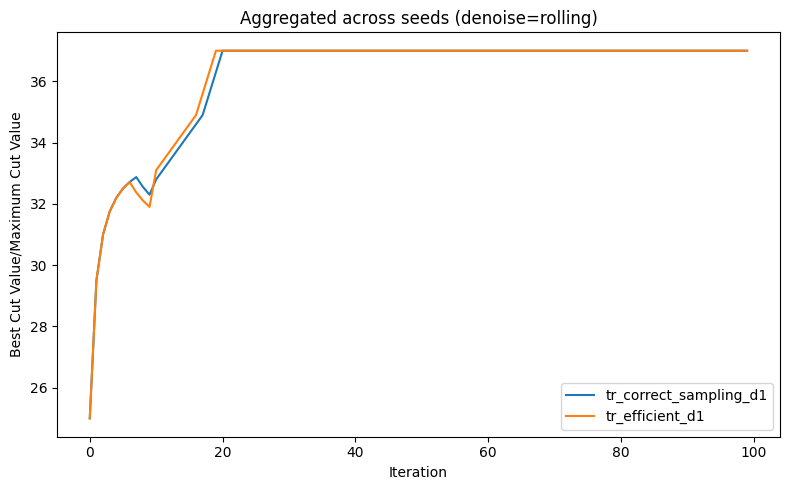

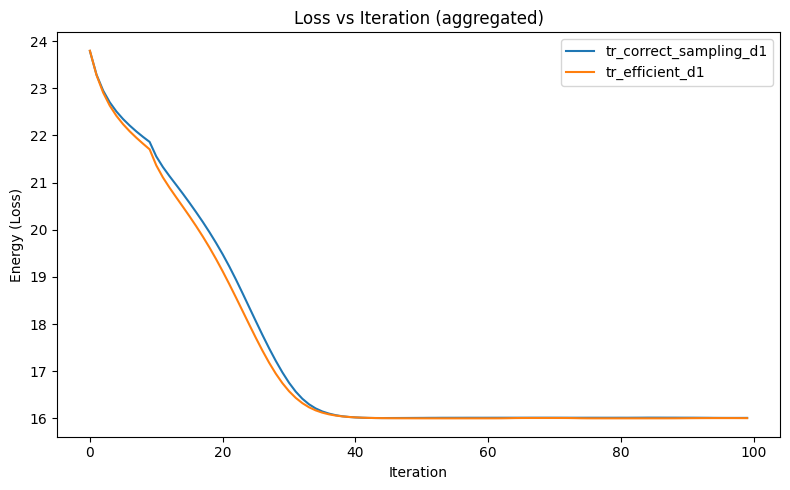

In [6]:
# # Suppose you have several seeds for each depth
# method_to_runids = {
#     "tr_efficient_d1": [ "run_id_seed1", "run_id_seed2", "run_id_seed3" ],
#     "tr_efficient_d2": [ "run_id_seed1", "run_id_seed2" ],
#     "tr_efficient_d3": [ "run_id_seed1", "run_id_seed2", "run_id_seed3" ],
# }
N_list = [4, 8, 16, 24, 36, 52, 70, 90, 100]
i =5
N = N_list[i]
N = 4816
graph_lookup = {(g['N'], g['graph_id']): g['G'] for g in exp_grid_loaded}
all_methods = ['tr_efficient', 'tr_correct_sampling']
method_to_runids = get_method_to_runids(
    outdir=f"bench_out_{N}",
    methods=  ['tr_efficient', 'tr_correct_sampling'],
    depths=[1],
    N=8,
    seeds=[0]
)
plot_compare_best_cut_aggregated(
    method_to_runids,
    cut_off_it=200,
    denoise="rolling",
    rolling_window=10,
    outdir=f"bench_out_{N}",
    all_graph=exp_grid_loaded,
    should_plot_gurobi=False
)
# plot aggregated loss curves
plot_compare_loss_aggregated(
    method_to_runids,
    cut_off_it=200,
    denoise="rolling",
    rolling_window=10,
    ylabel="Energy (Loss)",
    outdir=f"bench_out_{N}",
    all_graph=exp_grid_loaded
    
)


In [7]:
with open("experiment_grid.json", "r") as f:
    loaded = json.load(f)

# Convert lists back to tuples if you want
def convert_lists_to_tuples(obj):
    if isinstance(obj, list):
        # Check if list looks like an edge [(0,1), w]
        if len(obj) == 2 and isinstance(obj[0], list) and isinstance(obj[1], (int, float)):
            return (tuple(obj[0]), obj[1])
        else:
            return [convert_lists_to_tuples(x) for x in obj]
    if isinstance(obj, dict):
        return {k: convert_lists_to_tuples(v) for k, v in obj.items()}
    return obj

exp_grid_loaded = [convert_lists_to_tuples(entry) for entry in loaded]

print(exp_grid_loaded[0])  # should match your original structure
# {'N': 4, 'graph_id': 0, 'seed': 45854826, 'G': [((0, 3), 3), ((0, 2), 1), ((0, 1), 5), ((1, 2), 7), ((1, 3), 8), ((2, 3), 8)], 'depth': 1}


{'N': 4, 'graph_id': 0, 'seed': 45854826, 'G': [((0, 3), 3), ((0, 2), 1), ((0, 1), 5), ((1, 2), 7), ((1, 3), 8), ((2, 3), 8)], 'depth': 1}


In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import defaultdict

# --- small helper to fetch run_ids for (method, depth) buckets ---
def _runids_by_method_depth(
    outdir: str = "bench_out",
    methods=("tr_efficient", "tr_correct_sampling"),
    depths=(1, 3, 5),
    N: int | None = None,
    seeds: list[int] | None = None,
    optim: list[str] | None = None,
):
    """
    Returns: dict[(method, depth)] -> [run_ids...]
    """
    df = pd.read_csv(f"{outdir}/summary.csv")

    if methods is not None and "method" in df.columns:
        df = df[df["method"].isin(methods)]
    if depths is not None and "depth" in df.columns:
        df = df[df["depth"].isin(depths)]
    if N is not None and "N" in df.columns:
        df = df[df["N"] == N]
    if seeds is not None and "seed" in df.columns:
        df = df[df["seed"].isin(seeds)]
    if optim is not None and "optimizer" in df.columns:
        df = df[df["optimizer"].isin(optim)]

    bucket = defaultdict(list)
    for _, r in df.iterrows():
        key = (r.get("method"), int(r.get("depth")))
        bucket[key].append(r["run_id"])
    return bucket

# --- main 2x3 plotting ---
def plot_2x3_contraction_vs_sampling(
    depths=(1, 3, 5),
    contraction_method="tr_efficient",
    sampling_method="tr_correct_sampling",
    cut_off_it=300,
    denoise_best="running_best",  # "running_best" or "rolling"
    denoise_loss="rolling",       # "rolling" or "none"
    rolling_window=10,
    outdir="bench_out",
    all_graph=None,
    N: int | None = None,
    seeds: list[int] | None = None,
    optim: list[str] | None = None,
    contraction_label=None,
    sampling_label=None,
):
    """
    Creates a 2x3 figure:
      Row 1: normalized best-cut across iterations
      Row 2: loss (energy) across iterations
    Columns correspond to depths provided.
    """
    bucket = _runids_by_method_depth(
        outdir=outdir,
        methods=(contraction_method, sampling_method),
        depths=depths,
        N=N,
        seeds=seeds,
        optim=optim,
    )

    # Pretty labels
    contraction_label = contraction_label or contraction_method
    sampling_label    = sampling_label or sampling_method

    fig, axes = plt.subplots(2, len(depths), figsize=(4*len(depths)+1, 7), sharex="col")
    if len(depths) == 1:
        # Normalize axes shape if only one column
        axes = np.array(axes).reshape(2, 1)

    # loop over depths (columns)
    for j, d in enumerate(depths):
        ax_top = axes[0, j]
        ax_bot = axes[1, j]

        # ---- BEST CUT (top row) ----
        # contraction
        c_runs = bucket.get((contraction_method, d), [])
        if len(c_runs) > 0:
            it_c, med_c, q25_c, q75_c = aggregate_over_seeds(
                c_runs, g=None, cut_off_it=cut_off_it,
                denoise=denoise_best, rolling_window=rolling_window,
                outdir=outdir, all_graph=all_graph
            )
            line_c, = ax_top.plot(it_c, med_c, label=contraction_label)
            ax_top.fill_between(it_c, q25_c, q75_c, alpha=0.2)

        # sampling
        s_runs = bucket.get((sampling_method, d), [])
        if len(s_runs) > 0:
            it_s, med_s, q25_s, q75_s = aggregate_over_seeds(
                s_runs, g=None, cut_off_it=cut_off_it,
                denoise=denoise_best, rolling_window=rolling_window,
                outdir=outdir, all_graph=all_graph
            )
            line_s, = ax_top.plot(it_s, med_s, label=sampling_label)
            ax_top.fill_between(it_s, q25_s, q75_s, alpha=0.2)

        ax_top.set_title(f"D = {d} • Best Cut (normalized)")
        if j == 0:
            ax_top.set_ylabel("Best Cut Value/Maximum Cut Value")
        ax_top.grid(False)

        # ---- LOSS (bottom row) ----
        if len(c_runs) > 0:
            it_cL, med_cL, q25_cL, q75_cL = aggregate_loss_over_seeds(
                c_runs, cut_off_it=cut_off_it,
                denoise=denoise_loss, rolling_window=rolling_window,
                outdir=outdir, all_graph=all_graph
            )
            ax_bot.plot(it_cL, med_cL, label=contraction_label)
            ax_bot.fill_between(it_cL, q25_cL, q75_cL, alpha=0.2)

        if len(s_runs) > 0:
            it_sL, med_sL, q25_sL, q75_sL = aggregate_loss_over_seeds(
                s_runs, cut_off_it=cut_off_it,
                denoise=denoise_loss, rolling_window=rolling_window,
                outdir=outdir, all_graph=all_graph
            )
            ax_bot.plot(it_sL, med_sL, label=sampling_label)
            ax_bot.fill_between(it_sL, q25_sL, q75_sL, alpha=0.2)

        ax_bot.set_xlabel("Iteration")
        if j == 0:
            ax_bot.set_ylabel("Loss (Energy)")
        ax_bot.set_title(f"D = {d} • Loss")

    # one shared legend (top-right outside)
    handles, labels = axes[0, 0].get_legend_handles_labels()
    if not handles:
        # if first pane empty, try others
        for j in range(len(depths)):
            handles, labels = axes[0, j].get_legend_handles_labels()
            if handles:
                break
    if handles:
        fig.legend(handles, labels, loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.02))

    fig.suptitle("Maxcut Contraction vs Sampling (Aggregated across seeds) for N = {}".format(N), y=1.08, fontsize=12)
    fig.tight_layout()
    plt.show()


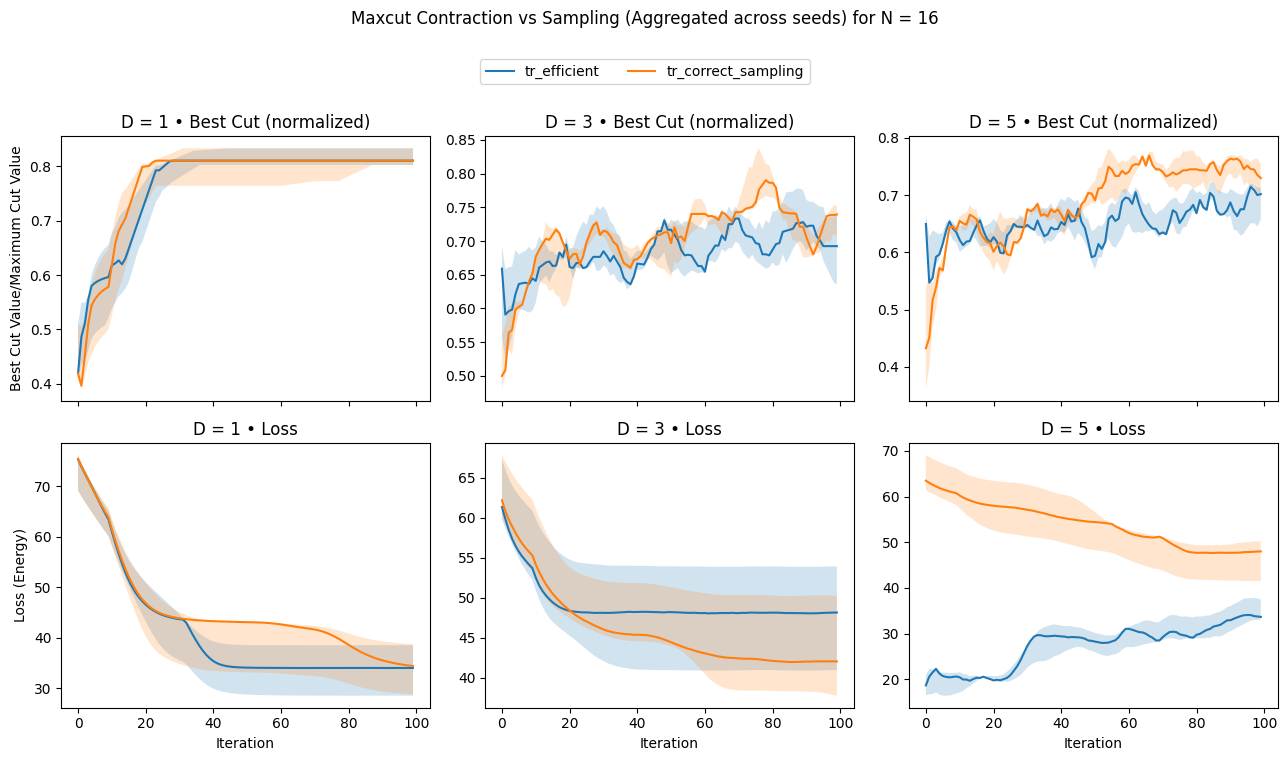

In [17]:
# Example
plot_2x3_contraction_vs_sampling(
    depths=(1,3,5),
    contraction_method="tr_efficient",
    sampling_method="tr_correct_sampling",
    cut_off_it=300,
    denoise_best="rolling",   # or "running_best"
    denoise_loss="rolling",
    rolling_window=10,
    outdir="bench_out_4816",
    all_graph=exp_grid_loaded,  # if you use per-seed graph lookup
    N=16,                   # optionally filter a specific N
    seeds=None,               # or pass [0,1,2]
    optim=None,               # e.g., ["AdamW"]
    contraction_label="tr_efficient",
    sampling_label="tr_correct_sampling",
)


In [10]:


with open("experiment_grid.json", "r") as f:
    loaded = json.load(f)

# Convert lists back to tuples if you want
def convert_lists_to_tuples(obj):
    if isinstance(obj, list):
        # Check if list looks like an edge [(0,1), w]
        if len(obj) == 2 and isinstance(obj[0], list) and isinstance(obj[1], (int, float)):
            return (tuple(obj[0]), obj[1])
        else:
            return [convert_lists_to_tuples(x) for x in obj]
    if isinstance(obj, dict):
        return {k: convert_lists_to_tuples(v) for k, v in obj.items()}
    return obj

exp_grid_loaded = [convert_lists_to_tuples(entry) for entry in loaded]
graph_lookup = {(g['N'], g['graph_id']): g['G'] for g in exp_grid_loaded}
print(graph_lookup[(24,0)])  # should match your original structure
# {'N': 4, 'graph_id': 0, 'seed': 45854826, 'G': [((0, 3), 3), ((0, 2), 1), ((0, 1), 5), ((1, 2), 7), ((1, 3), 8), ((2, 3), 8)], 'depth': 1}


[((0, 6), 2), ((0, 9), 9), ((0, 18), 7), ((1, 8), 10), ((1, 22), 9), ((1, 23), 6), ((2, 14), 8), ((2, 15), 4), ((2, 21), 10), ((3, 4), 4), ((3, 11), 7), ((3, 19), 4), ((4, 13), 6), ((4, 21), 9), ((5, 8), 7), ((5, 9), 4), ((5, 10), 9), ((6, 15), 2), ((6, 13), 4), ((7, 21), 2), ((7, 19), 3), ((7, 22), 8), ((8, 15), 3), ((9, 23), 9), ((10, 12), 3), ((10, 18), 7), ((11, 12), 6), ((11, 16), 5), ((12, 23), 10), ((13, 20), 6), ((14, 16), 3), ((14, 20), 10), ((16, 20), 7), ((17, 22), 7), ((17, 18), 8), ((17, 19), 7)]


In [11]:
# val = graph_lookup[(4,1)]
# print(val)

# hm = create_hamiltonian(24,val)
# print(hm)

# vv = make_hamiltonian(hm)
# print(vv)

# eigenvalues = np.linalg.eigvalsh(vv.to_matrix())
# print(eigenvalues)
# # for i in range(N):
# #     print(h.to_matrix()[i][i])

# M = max(eigenvalues)  # Highest energy (best cut)
# m = min(eigenvalues)  # Lowest energy (worst cut)

# print(f"Max Energy (M): {M}")
# print(f"Min Energy (m): {m}")


# GM = maxcut_value(val, GRB.MAXIMIZE)
# print(f"Gurobi Max Cut Value: {GM}")
# Gm = maxcut_value(val, GRB.MINIMIZE)
# print(f"Gurobi Min Cut Value: {Gm}")
# # def benchmark(val):

# print(sum(vv.coeff))